In [1]:
from mpi4py import MPI
import gmsh

# Initialize gmsh
gmsh.initialize()
gmsh.model.add("rect_with_partial_interface")

nx = 32
ny = 32
if MPI.COMM_WORLD.rank == 0:
    # --------------------------
    # Parameters
    # --------------------------
    Lx, Ly = 10.0, 10.0
    y_start, y_end = 8.0, 4.0
    x_start, x_end = 2.0, 8.0
    # lc = 0.3          # mesh size
    lc = 0.156
    order = 2          # element order

    # --------------------------
    # 1. Define rectangular domain Ω
    # --------------------------
    p1 = gmsh.model.occ.addPoint(0, 0, 0, lc)
    p2 = gmsh.model.occ.addPoint(Lx, 0, 0, lc)
    p3 = gmsh.model.occ.addPoint(Lx, Ly, 0, lc)
    p4 = gmsh.model.occ.addPoint(0, Ly, 0, lc)
    l1 = gmsh.model.occ.addLine(p1, p2)
    l2 = gmsh.model.occ.addLine(p2, p3)
    l3 = gmsh.model.occ.addLine(p3, p4)
    l4 = gmsh.model.occ.addLine(p4, p1)
    loop = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
    surf = gmsh.model.occ.addPlaneSurface([loop])

    # --------------------------
    # 2. Add an internal partial horizontal line Γ
    # --------------------------
    p5 = gmsh.model.occ.addPoint(x_start, y_start, 0, lc)
    p6 = gmsh.model.occ.addPoint(x_end, y_end, 0, lc)
    l5 = gmsh.model.occ.addLine(p5, p6)

    # gmsh.model.occ.synchronize()
    # gmsh.model.mesh.setTransfiniteCurve(l1, nx + 1)
    # gmsh.model.mesh.setTransfiniteCurve(l3, nx + 1)
    # gmsh.model.mesh.setTransfiniteCurve(l2, ny + 1)
    # gmsh.model.mesh.setTransfiniteCurve(l4, ny + 1)
    # gmsh.model.mesh.setTransfiniteSurface(surf, cornerTags=[p1, p2, p3, p4])

    # # Embed the internal line Γ (no fragmentation)
    # gmsh.model.mesh.embed(1, [l5], 2, surf)

    # --------------------------
    # 3. Fragment the surface with the internal line (split mesh)
    # --------------------------
    gmsh.model.occ.fragment([(2, surf)], [(1, l5)])
    gmsh.model.occ.synchronize()

    # --------------------------
    # 4. Define physical groups
    # --------------------------
    # Surface (bulk Ω)
    gmsh.model.addPhysicalGroup(2, [surf], 1)
    gmsh.model.setPhysicalName(2, 1, "Omega")

    # Identify the internal line (Γ)
    all_lines = gmsh.model.getEntities(dim=1)
    # print(all_lines)
    gamma_tag = all_lines[0][1]  # the last 1D entity created
    # print(gamma_tag)
    gmsh.model.addPhysicalGroup(1, [gamma_tag], 2)
    gmsh.model.setPhysicalName(1, 2, "Gamma")

    # Optionally, tag boundary (outer edges)
    outer_edges = [l1, l2, l3, l4]
    gmsh.model.addPhysicalGroup(1, outer_edges, 3)
    gmsh.model.setPhysicalName(1, 3, "Boundary")

    # --------------------------
    # 5. Generate and save mesh
    # --------------------------
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.setOrder(order)
    gmsh.write("diagonal.msh")

gmsh.finalize()


Info    : Meshing 1D...                                                                                                  
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00113039s, CPU 0.000827s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.180318s, CPU 0.180768s)
Info    : 5078 nodes 10207 elements
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 60%] Meshing curve 8 order 2
Info    : [ 70%] Meshing curve 9 order 2
Info    : [ 90%] Meshing surface 1 order 2


Info    : Surface mesh: worst distortion = 1 (0 elements in ]0, 0.2]); worst gamma = 0.65881
Info    : Done meshing order 2 (Wall 0.0441804s, CPU 0.047708s)
Info    : Writing 'diagonal.msh'...
Info    : Done writing 'diagonal.msh'


In [2]:
from mpi4py import MPI
from dolfinx import mesh, fem
import ufl
import numpy as np

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (similar to Γ tagging in the workshop)
# ---------------------------------------------------------------------
# Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
from dolfinx.io import gmsh as gmshio
# Read the same .msh
msh, cell_markers, facet_markers = gmshio.read_from_msh("diagonal.msh", MPI.COMM_WORLD, 0, gdim=2)[0:3]


# Extract the 1D interface mesh from the 2D mesh (like igridView)
# interface = mesh.create_submesh(domain, domain.topology.dim - 1, np.arange(domain.topology.index_map(domain.topology.dim - 1).size_local, dtype=np.int32))[0]


Info    : Reading 'diagonal.msh'...
Info    : 12 entities
Info    : 20049 nodes
Info    : 9941 elements
Info    : Done reading 'diagonal.msh'


In [3]:
tdim = msh.topology.dim  # 2
fdim = tdim - 1             # 1

# Find all facets tagged as Gamma (tag=2)
omega = msh
gamma_entities = facet_markers.find(2)

# Create a submesh for Γ (same as gamma in the JSDokken example)
gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

In [4]:
print(gamma.geometry.x[:])

[[2.         8.         0.        ]
 [2.12765957 7.91489362 0.        ]
 [2.06382979 7.95744681 0.        ]
 [2.25531915 7.82978723 0.        ]
 [2.19148936 7.87234043 0.        ]
 [2.38297872 7.74468085 0.        ]
 [2.31914894 7.78723404 0.        ]
 [2.5106383  7.65957447 0.        ]
 [2.44680851 7.70212766 0.        ]
 [2.63829787 7.57446809 0.        ]
 [2.57446809 7.61702128 0.        ]
 [2.76595745 7.4893617  0.        ]
 [2.70212766 7.53191489 0.        ]
 [2.89361702 7.40425532 0.        ]
 [2.82978723 7.44680851 0.        ]
 [3.0212766  7.31914894 0.        ]
 [2.95744681 7.36170213 0.        ]
 [3.14893617 7.23404255 0.        ]
 [3.08510638 7.27659574 0.        ]
 [3.27659574 7.14893617 0.        ]
 [3.21276596 7.19148936 0.        ]
 [3.40425532 7.06382979 0.        ]
 [3.34042553 7.10638298 0.        ]
 [3.53191489 6.9787234  0.        ]
 [3.46808511 7.0212766  0.        ]
 [3.65957447 6.89361702 0.        ]
 [3.59574468 6.93617021 0.        ]
 [3.78723404 6.80851064 0.  

In [5]:
# Define interface tag ID (as defined in Gmsh)
Gamma_tag = 2  # <-- replace with your actual tag ID for the interface Γ

# ---------------------------------------------------------------------
# 2. Function spaces
# ---------------------------------------------------------------------
order = 2
V_m = fem.functionspace(omega, ("Lagrange", order))  # bulk Ω
V_f = fem.functionspace(gamma, ("Lagrange", order))   # interface Γ
V_l = fem.functionspace(gamma, ("Lagrange", order))   # multiplier space on Γ
W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

# ---------------------------------------------------------------------
# 3. Trial and Test functions
# ---------------------------------------------------------------------
phi, psi, mu = ufl.TestFunctions(W)
dp_m, dp_f, dl = ufl.TrialFunctions(W)
p_m = fem.Function(V_m, name="p_m")
p_f = fem.Function(V_f, name="p_f")
lmbd = fem.Function(V_f, name="lmbd")

# ---------------------------------------------------------------------
# 4. Spatial coordinates and given data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(msh)
f_m = fem.Constant(msh, 0.0)
f_f = fem.Constant(msh, 0.0)

k_m = fem.Constant(omega, 1.0)
k_f = fem.Constant(gamma, 100.0)


In [6]:
dx = ufl.Measure("dx", domain=omega)
ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
dx_f = ufl.Measure("dx", domain=gamma)

In [7]:
# ---------------------------------------------------------------------
# 5. Weak formulations
# ---------------------------------------------------------------------

# --- Bulk domain Ω ---------------------------------------------------
a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
# Coupling term with interface (approximate; corresponds to avg/trace in DUNE)
# In the Dokken example, coupling to Γ is done via ds(Gamma_tag)
# Here we use the interface integral directly on ds(Gamma_tag)
# (You can later replace lmbd with an actual trace variable or interface function)
a_m1 = -lmbd * phi * ds
a_m = a_m0 + a_m1
L_m = f_m * phi * dx

# --- Interface Γ -----------------------------------------------------
a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
a_f1 = lmbd * psi * ds
a_f = a_f0 + a_f1
L_f = f_f * psi * ds
# a_f0 = ufl.inner(ufl.grad(p_f), ufl.grad(psi)) * dx_f
# a_f1 = lmbd * psi * dx_f
# a_f = a_f0 + a_f1
# L_f = f_f * psi * dx_f

# --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
# Dokken’s example handles this through interface coupling on ds(Gamma_tag)
a_l0 = p_m * mu * ds
a_l1 = -p_f * mu * ds
a_l = a_l0 + a_l1
L_l = fem.Constant(msh, 0.0) * mu * ds

# a_l0 = p_m * mu * ds
# a_l1 = -p_f * mu * dx_f
# a_l = a_l0 + a_l1
# L_l = fem.Constant(msh, 0.0) * mu * dx_f

# ---------------------------------------------------------------------
# 6. Combine interface weak form
# ---------------------------------------------------------------------
a_gamma = a_f + a_l
L_gamma = L_f + L_l

# ---------------------------------------------------------------------
# Print symbolic forms (optional sanity check)
# ---------------------------------------------------------------------
print("a_m =", a_m)
print("a_gamma =", a_gamma)

a_m = { ({ A | A_{i_8} = c_2 * (grad(p_m))[i_8] }) : (grad(v_0^0)) } * dx(<Mesh #0>[everywhere], {})
  +  { v_0^0 * -1 * lmbd } * ds(<Mesh #0>[2], {})
a_gamma = { ({ A | A_{i_9} = c_3 * (grad(p_f))[i_9] }) : (grad(v_0^1)) } * ds(<Mesh #0>[2], {})
  +  { v_0^1 * lmbd } * ds(<Mesh #0>[2], {})
  +  { v_0^2 * p_m } * ds(<Mesh #0>[2], {})
  +  { v_0^2 * -1 * p_f } * ds(<Mesh #0>[2], {})


In [8]:
F = a_m - L_m + a_gamma - L_gamma
residual = ufl.extract_blocks(F)

In [9]:
jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
J = ufl.extract_blocks(jac)

In [10]:
# Compute bounding box to locate sides
coords = omega.geometry.x
x = coords[:, 0]
y = coords[:, 1]

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Tolerance for side detection
tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

# Union of all boundary dofs for which we enforce a value
all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))

# Build a Function-valued BC so we can assign side-dependent values
p_m_bc = fem.Function(V_m)
p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
p_m_bc.x.array[left_dofs] = 10.0
p_m_bc.x.array[top_dofs]  = 10.0

# One BC object over the union of dofs with piecewise values
bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

bcs = [bc_pm]

In [11]:
print("DOFs in p_m:", p_m.function_space.dofmap.index_map.size_global)
print("DOFs in p_f:", p_f.function_space.dofmap.index_map.size_global)
print("DOFs in λ:", lmbd.function_space.dofmap.index_map.size_global)
total_dofs = (
    p_m.function_space.dofmap.index_map.size_global
    + p_f.function_space.dofmap.index_map.size_global
    + lmbd.function_space.dofmap.index_map.size_global
)
print("Total DOFs:", total_dofs)


DOFs in p_m: 20049
DOFs in p_f: 95
DOFs in λ: 95
Total DOFs: 20239


In [12]:
from dolfinx.fem import petsc
entity_maps = [gamma_to_omega]
# # --- Assemble J once (with entity_maps) ---
# A = petsc.assemble_matrix(
#     fem.form(J, entity_maps=entity_maps),  # <-- pass it here
#     bcs=bcs,
# )
# A.assemble()

In [13]:


# entity_maps = [gamma_to_omega]
# entity_maps = [gamma_to_omega]
nlp = petsc.NonlinearProblem(
    residual,
    u=[p_m, p_f, lmbd],
    J=J,
    bcs=bcs,
    entity_maps=entity_maps,
    petsc_options={
        "snes_monitor": None,
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "mat_mumps_icntl_14": 120,
        "ksp_error_if_not_converged": True,
        "snes_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_",
)
max_iterations = 25
normed_diff = 0
tol = 1e-5

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")

  0 SNES Function norm 3.053395936267e+02
  1 SNES Function norm 9.021318651650e+00
  2 SNES Function norm 2.481891910385e+00
  3 SNES Function norm 1.252448840413e+00
  4 SNES Function norm 8.194415458842e-01
  5 SNES Function norm 6.099780063238e-01
  6 SNES Function norm 5.246215063323e-01
  7 SNES Function norm 5.061640081770e-01
  8 SNES Function norm 6.142077007670e-02
  9 SNES Function norm 4.938169663001e-02
 10 SNES Function norm 4.167263679260e-02
 11 SNES Function norm 3.648770857269e-02
 12 SNES Function norm 3.299298284084e-02
 13 SNES Function norm 3.079345448130e-02
 14 SNES Function norm 2.968703232280e-02
 15 SNES Function norm 2.954822142020e-02
 16 SNES Function norm 1.409969019200e-03
 17 SNES Function norm 1.268437812377e-03
 18 SNES Function norm 1.199786638933e-03
 19 SNES Function norm 1.195155893171e-03
 20 SNES Function norm 1.069330986584e-04
 21 SNES Function norm 9.141787875414e-05
 22 SNES Function norm 7.908677592371e-05
 23 SNES Function norm 6.944639634

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


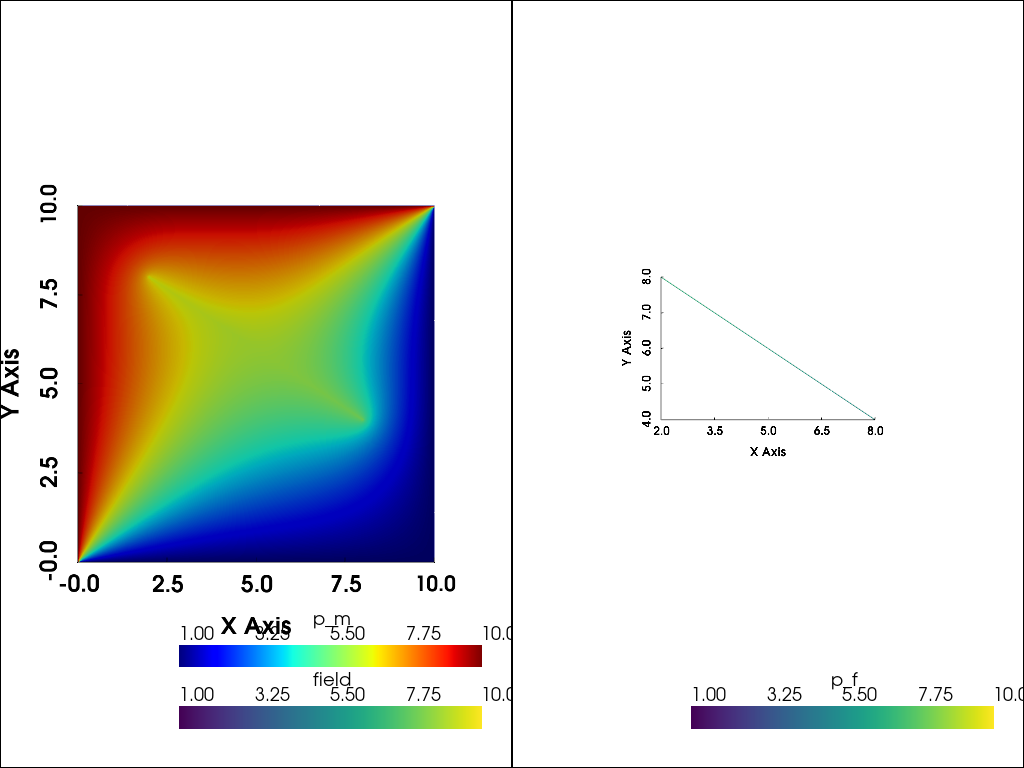

In [14]:
import numpy as np
import pyvista as pv
import dolfinx
from dolfinx import plot

# --- helper: build a PyVista grid from a scalar Function (CG or DG) ---
def function_to_pyvista_grid(u):
    # Newer dolfinx uses create_vtk_mesh; fall back to vtk_mesh if needed
    try:
        topology, cell_types, geometry = plot.create_vtk_mesh(u.function_space)
    except AttributeError:
        topology, cell_types, geometry = plot.vtk_mesh(u.function_space)

    grid = pv.UnstructuredGrid(topology, cell_types, geometry)

    # Attach scalar values on points
    # For scalar fields, u.x.array is 1D of length n_dofs
    values = u.x.array
    # If the FE space is vector-valued, drop to first component (not expected here)
    if values.ndim > 1:
        values = values.reshape(-1)
    grid.point_data["field"] = values.real  # use .real in case of complex
    return grid

# --- Build PyVista grids for p_m and p_f ---
grid_pm = function_to_pyvista_grid(p_m)
grid_pf = function_to_pyvista_grid(p_f)

# Optional: consistent ranges so the color scales match (remove if you prefer autoscale)
vmin = min(grid_pm.point_data["field"].min(), grid_pf.point_data["field"].min())
vmax = max(grid_pm.point_data["field"].max(), grid_pf.point_data["field"].max())

# --- Plot side-by-side, inspired by your style (wireframe + shaded) ---
plotter = pv.Plotter(shape=(1, 2), border=True)

# Left: p_m
plotter.subplot(0, 0)
plotter.add_mesh(grid_pm.copy(deep=True), style="wireframe", color="b")
plotter.add_mesh(
    grid_pm, scalars="field", show_edges=False, lighting=True, clim=[vmin, vmax],cmap='jet'
)
plotter.add_scalar_bar(title="p_m")
plotter.show_bounds()
plotter.view_xy()

# Right: p_f
plotter.subplot(0, 1)
plotter.add_mesh(grid_pf.copy(deep=True), style="wireframe", color="b")
plotter.add_mesh(
    grid_pf, scalars="field", show_edges=False, lighting=True, clim=[vmin, vmax]
)
plotter.add_scalar_bar(title="p_f")
plotter.show_bounds()
plotter.view_xy()

# Link cameras so rotations/zooms match
plotter.link_views()
plotter.show()


In [15]:
grid_pf

UnstructuredGrid (0x7ac0e5828820)
  N Cells:    47
  N Points:   95
  X Bounds:   2.000e+00, 8.000e+00
  Y Bounds:   4.000e+00, 8.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   1

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


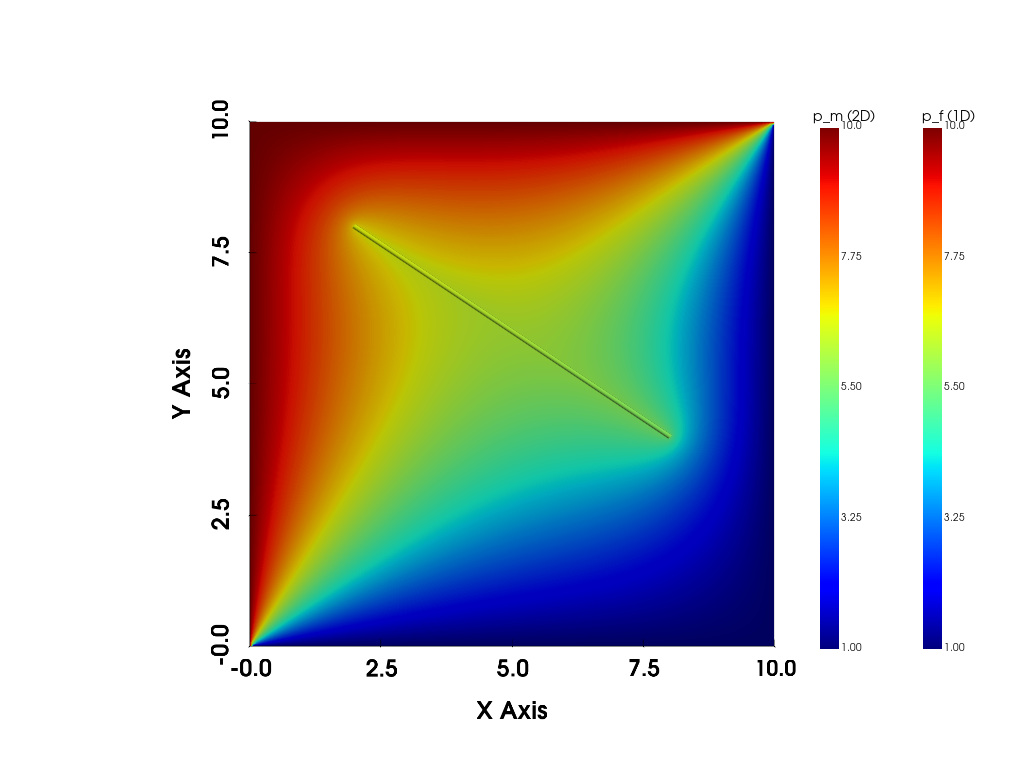

In [16]:
import numpy as np
import pyvista as pv
from dolfinx import plot

# --- Convert 2D field (p_m) ---
topology2, cell_types2, geometry2 = plot.vtk_mesh(p_m.function_space)
grid_2d = pv.UnstructuredGrid(topology2, cell_types2, geometry2)
grid_2d.point_data["p_m"] = p_m.x.array.real

# --- Convert 1D field (p_f) ---
topology1, cell_types1, geometry1 = plot.vtk_mesh(p_f.function_space)
grid_1d = pv.UnstructuredGrid(topology1, cell_types1, geometry1)
grid_1d.point_data["p_f"] = p_f.x.array.real

# --- Create plotter ---
plotter = pv.Plotter()

# Add 2D mesh with filled colormap
plotter.add_mesh(
    grid_2d,
    scalars="p_m",
    cmap="jet",
    show_edges=False,
    lighting=True,
    # scalar_bar_args={"title": "p_m (2D)"}, 
    clim=[vmin, vmax],
    scalar_bar_args={
        "title": "p_m (2D)",
        "vertical": True,
        "position_x": 0.8,  # right side
        "position_y": 0.15,
        "width": 0.05,
        "height": 0.7,
        "title_font_size": 14,
        "label_font_size": 10,
    },
)

# Add 1D interface as a line on top, thicker and with its own scalar color
plotter.add_mesh(
    grid_1d,
    scalars="p_f",
    cmap="jet",
    line_width=5,
    show_edges=False,
    render_lines_as_tubes=True,
    # scalar_bar_args={"title": "p_f (1D)"}, 
    clim=[vmin, vmax],
    scalar_bar_args={
        "title": "p_f (1D)",
        "vertical": True,
        "position_x": 0.9,  # slightly to the right of first colorbar
        "position_y": 0.15,
        "width": 0.05,
        "height": 0.7,
        "title_font_size": 14,
        "label_font_size": 10,
    },
)

# --- Cosmetics ---
plotter.show_bounds()
plotter.view_xy()
plotter.show()

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


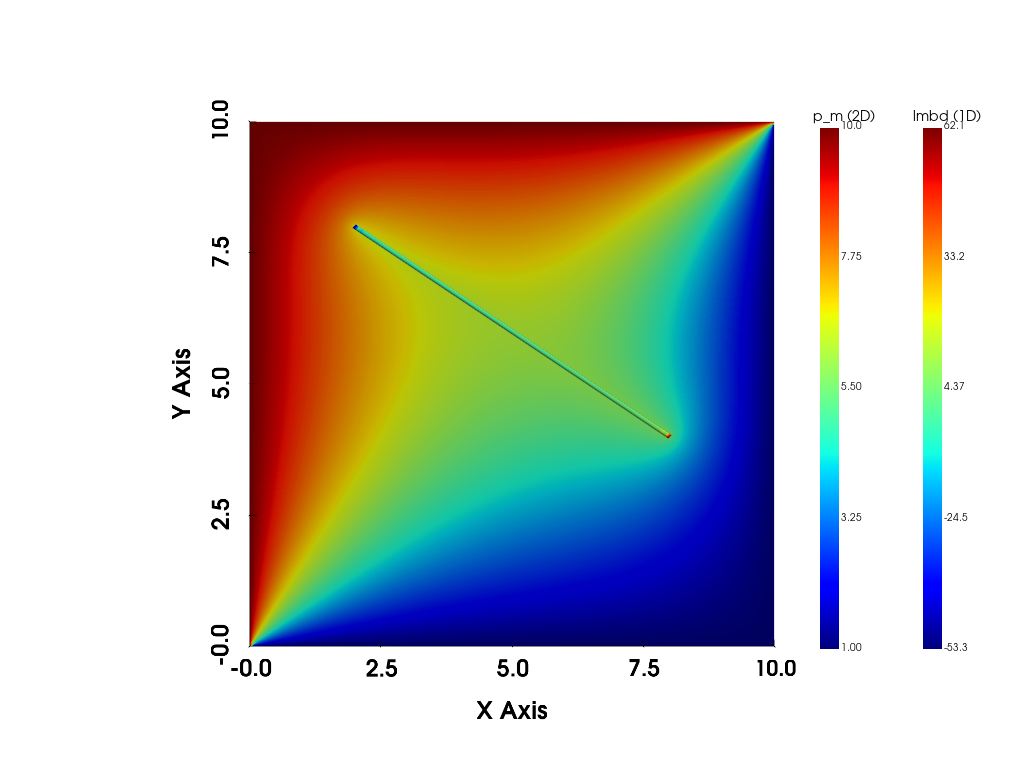

In [17]:
import numpy as np
import pyvista as pv
from dolfinx import plot

# --- Convert 2D field (p_m) ---
topology2, cell_types2, geometry2 = plot.vtk_mesh(p_m.function_space)
grid_2d = pv.UnstructuredGrid(topology2, cell_types2, geometry2)
grid_2d.point_data["p_m"] = p_m.x.array.real

# --- Convert 1D field (p_f) ---
topology1, cell_types1, geometry1 = plot.vtk_mesh(lmbd.function_space)
grid_1d = pv.UnstructuredGrid(topology1, cell_types1, geometry1)
grid_1d.point_data["lmbd"] = lmbd.x.array.real

# --- Create plotter ---
plotter = pv.Plotter()

# Add 2D mesh with filled colormap
plotter.add_mesh(
    grid_2d,
    scalars="p_m",
    cmap="jet",
    show_edges=False,
    lighting=True,
    # scalar_bar_args={"title": "p_m (2D)"}, 
    clim=[vmin, vmax],
    scalar_bar_args={
        "title": "p_m (2D)",
        "vertical": True,
        "position_x": 0.8,  # right side
        "position_y": 0.15,
        "width": 0.05,
        "height": 0.7,
        "title_font_size": 14,
        "label_font_size": 10,
    },
)

# Add 1D interface as a line on top, thicker and with its own scalar color
plotter.add_mesh(
    grid_1d,
    scalars="lmbd",
    cmap="jet",
    line_width=5,
    show_edges=False,
    render_lines_as_tubes=True,
    # scalar_bar_args={"title": "p_f (1D)"}, 
    # clim=[vmin, vmax],
    scalar_bar_args={
        "title": "lmbd (1D)",
        "vertical": True,
        "position_x": 0.9,  # slightly to the right of first colorbar
        "position_y": 0.15,
        "width": 0.05,
        "height": 0.7,
        "title_font_size": 14,
        "label_font_size": 10,
    },
)

# --- Cosmetics ---
plotter.show_bounds()
plotter.view_xy()
plotter.show()

In [18]:
from dolfinx.io import XDMFFile
from mpi4py import MPI

with XDMFFile(MPI.COMM_SELF, "solution.xdmf", "w") as xdmf:
    xdmf.write_mesh(p_m.function_space.mesh)
    xdmf.write_function(p_m)
    xdmf.write_function(p_f)
    xdmf.write_function(lmbd)

In [19]:
import numpy as np
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import cKDTree

# 1) Load MRST data (Pa) with header x,y,pressure
data = np.loadtxt("pressure_field_G.csv", delimiter=",", skiprows=1)
x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# Optional: sanity-check domain if needed (MRST is [0,10]x[0,10])
# assert x_mrst.min() >= 0 and x_mrst.max() <= 10 and y_mrst.min() >= 0 and y_mrst.max() <= 10

# 2) Interpolant from scattered MRST cell centroids to arbitrary (x,y)
interp = LinearNDInterpolator(np.c_[x_mrst, y_mrst], p_mrst, fill_value=np.nan)

# 3) Build u_ref in the SAME space as p_m by sampling MRST at p_m's DoF coordinates
V = p_m.function_space
xdofs = V.tabulate_dof_coordinates()            # shape: (n_local_dofs, gdim)
vals = np.array([interp(x, y) for x, y in xdofs[:, :2]])

# Fallback for points slightly outside MRST convex hull: nearest neighbor
if np.any(np.isnan(vals)):
    nn = np.isnan(vals)
    tree = cKDTree(np.c_[x_mrst, y_mrst])
    _, idx = tree.query(xdofs[nn, :2])
    vals[nn] = p_mrst[idx]

u_ref = fem.Function(V)
u_ref.x.array[:] = vals

# 4) Compute errors (absolute and relative) in L2 and H1-seminorms over the same mesh
dx = ufl.dx(domain=V.mesh)
e = fem.Function(V)
e.x.array[:] = p_m.x.array - u_ref.x.array

L2_err = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(e, e) * dx)))
L2_ref = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(u_ref, u_ref) * dx)))
rel_L2 = L2_err / (L2_ref + 1e-30)

H1s_err = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(e), ufl.grad(e)) * dx)))
H1s_ref = np.sqrt(fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(u_ref), ufl.grad(u_ref)) * dx)))
rel_H1s = H1s_err / (H1s_ref + 1e-30)

# if comm.rank == 0:
print("=== MRST vs FEniCSx (p_m) ===")
print(f"L2 error       = {L2_err:.6e}")
print(f"Relative L2    = {rel_L2:.6e}")
print(f"H1 seminorm    = {H1s_err:.6e}")
print(f"Relative H1    = {rel_H1s:.6e}")

=== MRST vs FEniCSx (p_m) ===
L2 error       = 1.174203e+00
Relative L2    = 1.901125e-02
H1 seminorm    = 5.874275e+00
Relative H1    = 2.434306e-01


In [20]:
# h = 0.5
# === MRST vs FEniCSx (p_m) ===
# L2 error       = 1.215990e+00
# Relative L2    = 1.968819e-02
# H1 seminorm    = 5.752151e+00
# Relative H1    = 2.611519e-01

# h = 0.1
# === MRST vs FEniCSx (p_m) ===
# L2 error       = 1.158913e+00
# Relative L2    = 1.876360e-02
# H1 seminorm    = 6.011193e+00
# Relative H1    = 2.426439e-01

# h = 0.05
# === MRST vs FEniCSx (p_m) ===
# L2 error       = 1.106317e+00
# Relative L2    = 1.791195e-02
# H1 seminorm    = 7.050860e+00
# Relative H1    = 2.791032e-01

In [21]:
p_mrst

array([5.50000009, 3.04084436, 2.20422092, ..., 6.16673611, 6.16647962,
       6.16629545], shape=(1048656,))

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


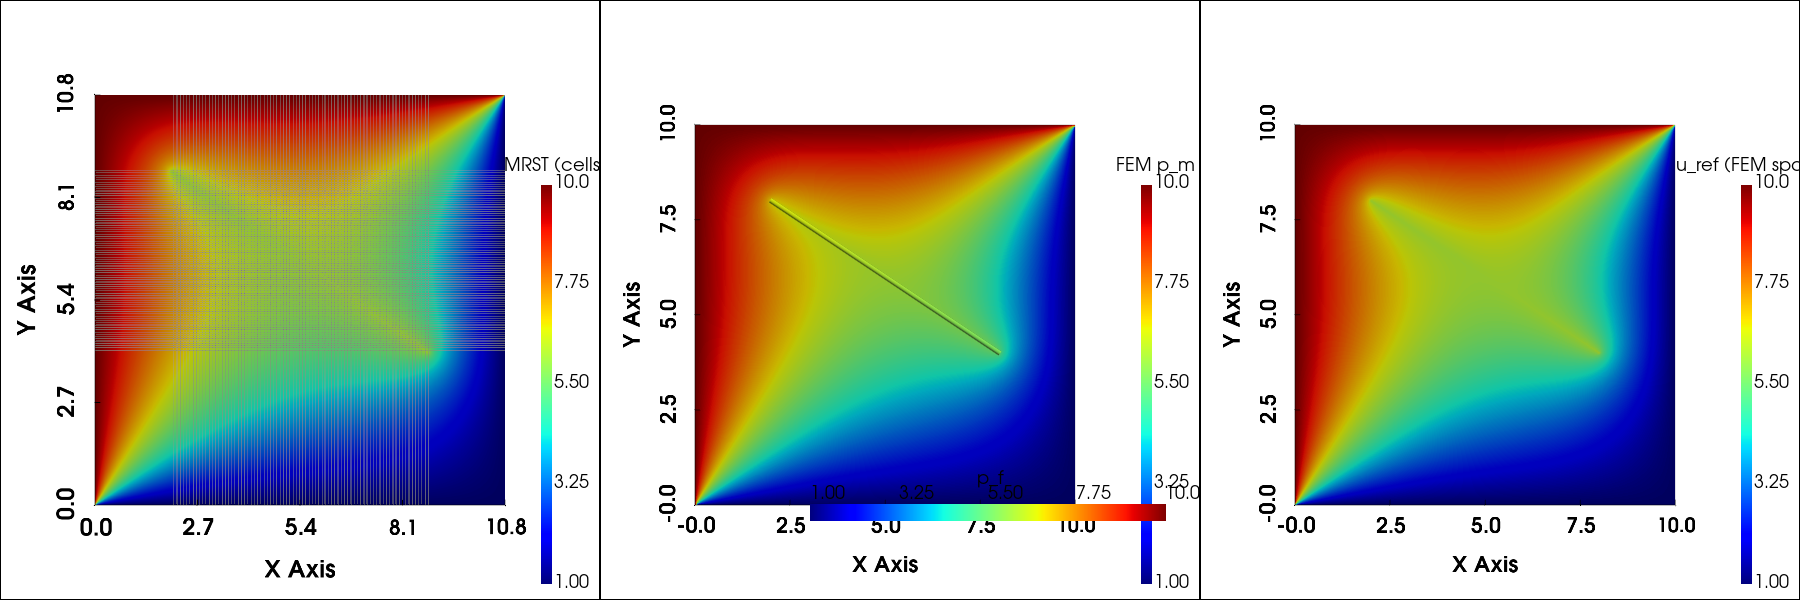

In [22]:
# ---------- MRST -> UniformGrid (cell-centered) ----------
xs = np.unique(x_mrst)
ys = np.unique(y_mrst)
nx, ny = len(xs), len(ys)

# Map scattered centroids to a 2D array (row=y, col=x)
ix = np.searchsorted(xs, x_mrst)
iy = np.searchsorted(ys, y_mrst)
p_mrst_2d = np.full((ny, nx), np.nan, dtype=float)
p_mrst_2d[iy, ix] = p_mrst

dx = xs[1] - xs[0]
dy = ys[1] - ys[0]

ug = pv.ImageData()
ug.dimensions = (nx + 1, ny + 1, 1)
ug.spacing = (dx, dy, 1.0)
ug.origin = (xs.min() - 0.5 * dx, ys.min() - 0.5 * dy, 0.0)
ug.cell_data["p_mrst"] = p_mrst_2d.T.ravel(order="F")

# ---------- Convert FEM fields to PyVista ----------
# 2D background (p_m)
topo2, ctype2, geom2 = plot.vtk_mesh(p_m.function_space)
grid_2d = pv.UnstructuredGrid(topo2, ctype2, geom2)
grid_2d.point_data["p_m"] = p_m.x.array.real

# 1D fracture (p_f)
topo1, ctype1, geom1 = plot.vtk_mesh(p_f.function_space)
grid_1d = pv.UnstructuredGrid(topo1, ctype1, geom1)
grid_1d.point_data["p_f"] = p_f.x.array.real

# u_ref on same 2D mesh as p_m
grid_ref = pv.UnstructuredGrid(topo2, ctype2, geom2.copy())
grid_ref.point_data["u_ref"] = u_ref.x.array.real

# ---------- Shared color limits ----------
mrst_min, mrst_max = float(np.nanmin(p_mrst_2d)), float(np.nanmax(p_mrst_2d))
fem_min = min(grid_2d.point_data["p_m"].min(),
              grid_1d.point_data["p_f"].min(),
              grid_ref.point_data["u_ref"].min())
fem_max = max(grid_2d.point_data["p_m"].max(),
              grid_1d.point_data["p_f"].max(),
              grid_ref.point_data["u_ref"].max())
vmin, vmax = min(mrst_min, fem_min), max(mrst_max, fem_max)

# ---------- Plot (1 x 3) ----------
plotter = pv.Plotter(shape=(1, 3), window_size=(1800, 600))

# Panel 1: MRST (cells)
plotter.subplot(0, 0)
plotter.add_mesh(
    ug, scalars="p_mrst", cmap="jet", show_edges=False, lighting=True,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "MRST (cells)", "vertical": True, "width": 0.05, "height": 0.7}
)
plotter.show_bounds(); plotter.view_xy()

# Panel 2: FEM p_m (nodes) + p_f (line)
plotter.subplot(0, 1)
plotter.add_mesh(
    grid_2d, scalars="p_m", cmap="jet", show_edges=False, lighting=True,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
)
plotter.add_mesh(
    grid_1d, scalars="p_f", cmap="jet", render_lines_as_tubes=True,
    line_width=5, show_edges=False, clim=[vmin, vmax]
)
plotter.show_bounds(); plotter.view_xy()

# Panel 3: u_ref (nodes)
plotter.subplot(0, 2)
plotter.add_mesh(
    grid_ref, scalars="u_ref", cmap="jet", show_edges=False, lighting=True,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "u_ref (FEM space)", "vertical": True, "width": 0.05, "height": 0.7}
)
plotter.show_bounds(); plotter.view_xy()

plotter.link_views()
plotter.show()

In [23]:
mrst_min, mrst_max 

(1.00000853562434, 9.99998516711542)

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


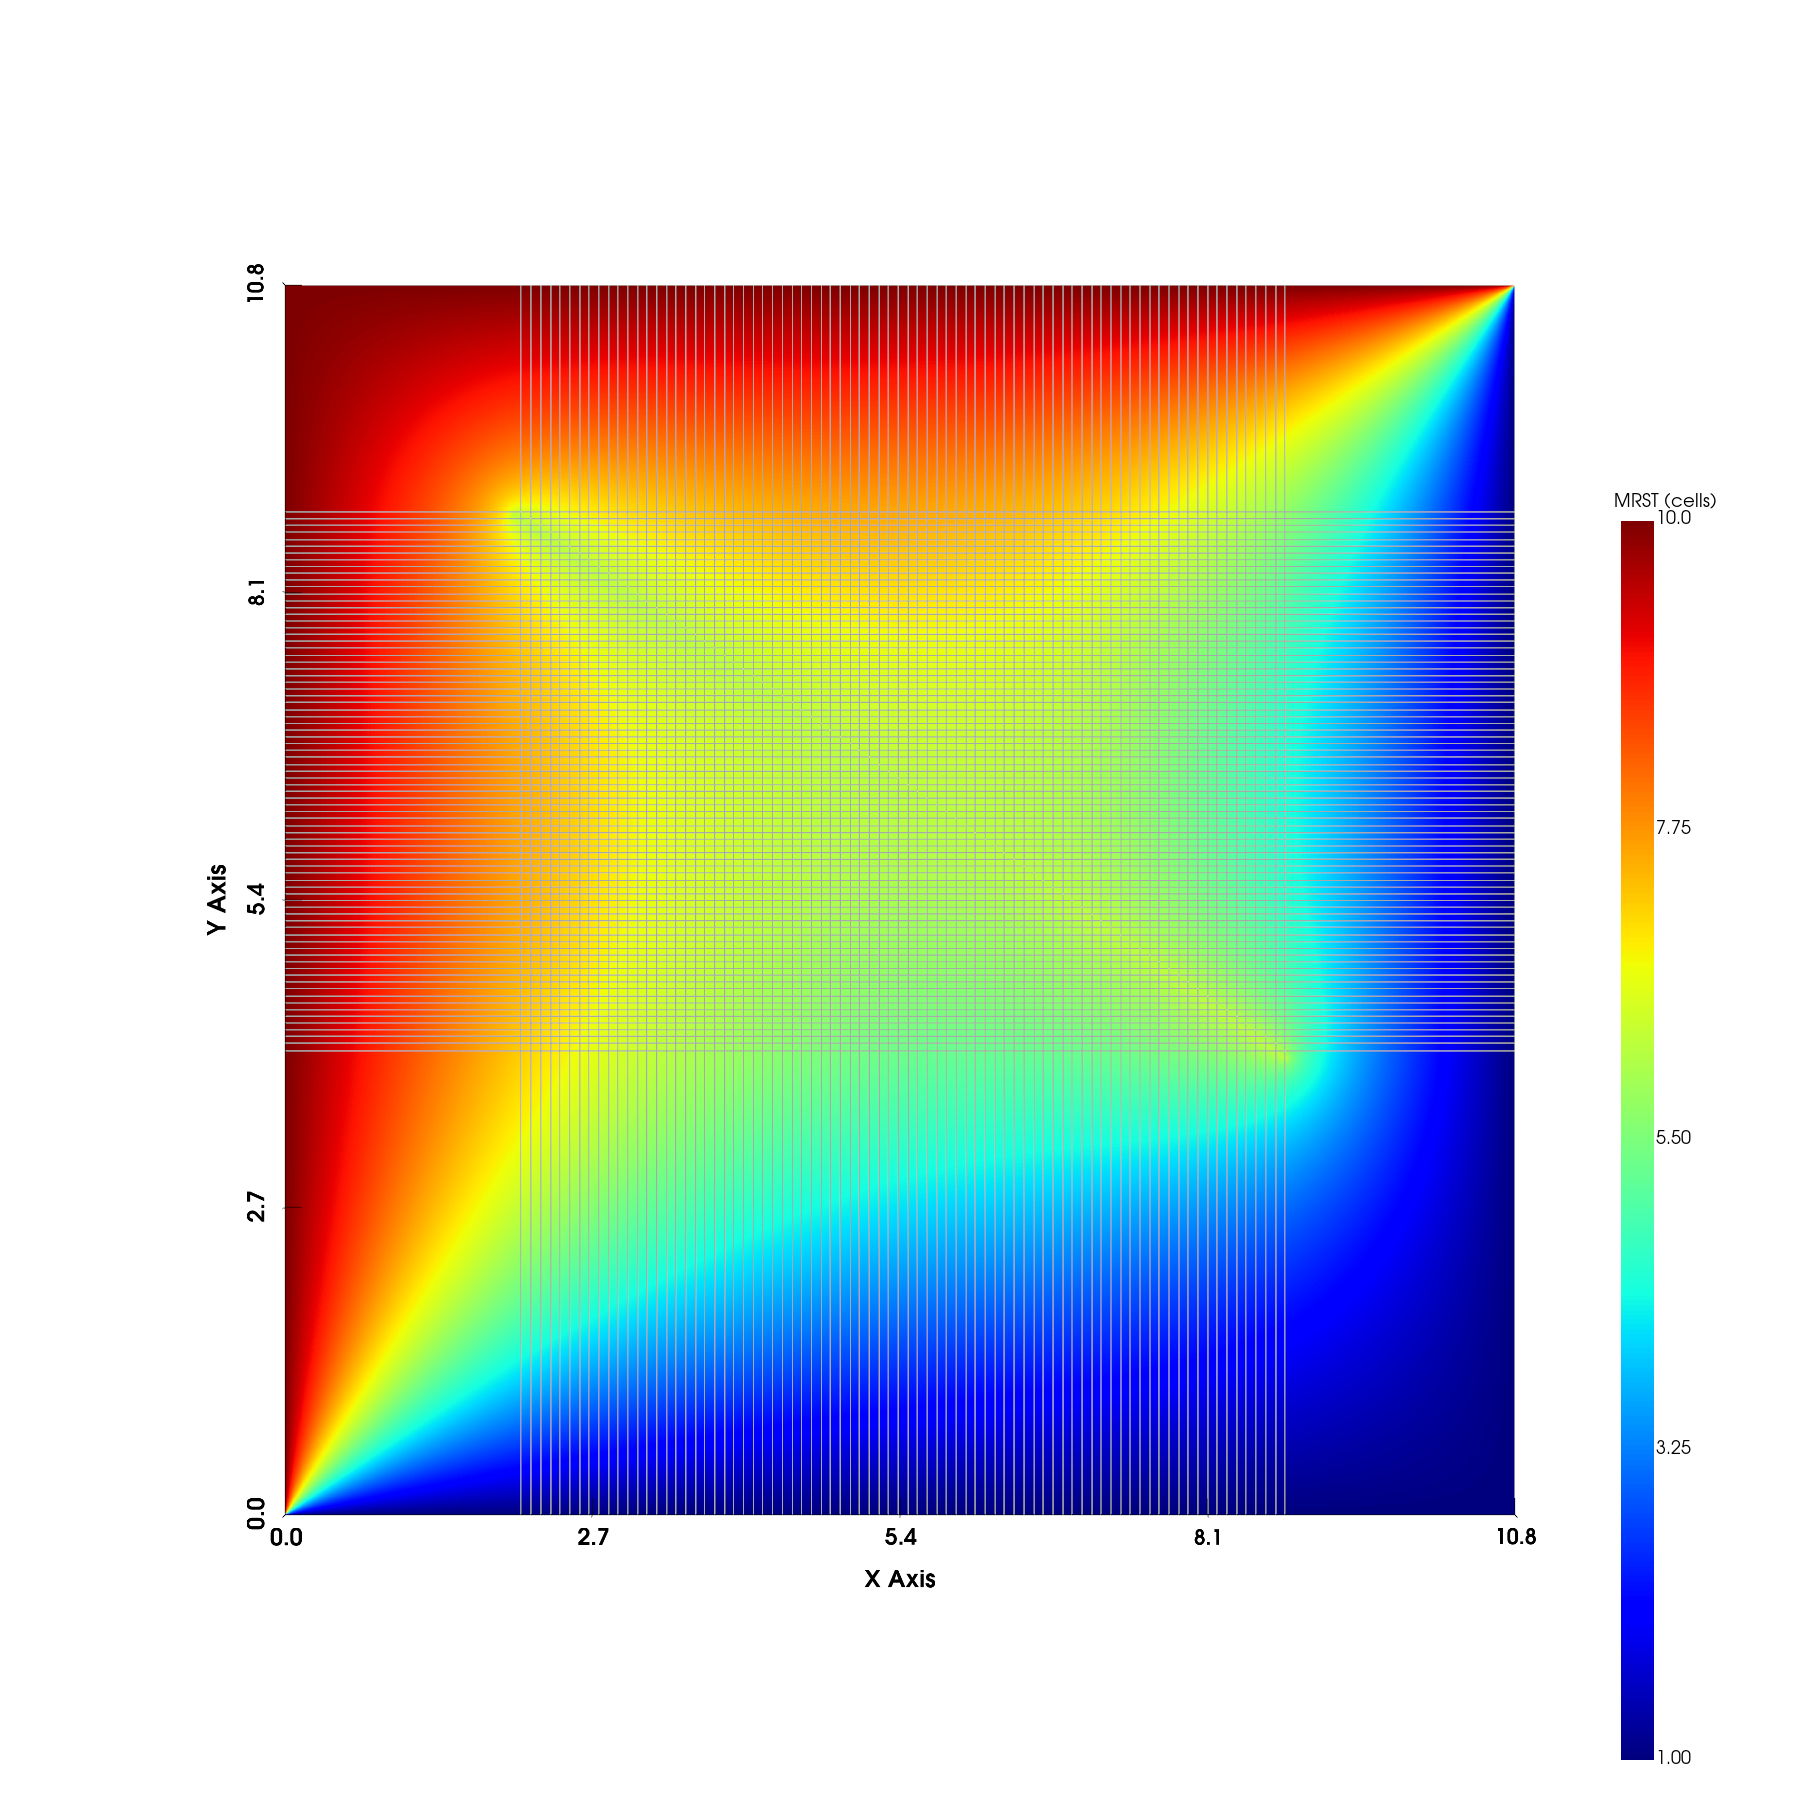

In [24]:
plotter = pv.Plotter(shape=(1, 1), window_size=(1800, 1800))

# Panel 1: MRST (cells)
plotter.subplot(0, 0)
plotter.add_mesh(
    ug, scalars="p_mrst", cmap="jet", show_edges=False, lighting=False,
    clim=[vmin, vmax],
    scalar_bar_args={"title": "MRST (cells)", "vertical": True, "width": 0.05, "height": 0.7}
)
plotter.show_bounds(); plotter.view_xy()
plotter.show()

/home/muchamad/PhD/fenicsx/lib/python3.13/site-packages/pyvista/jupyter/notebook.py:56: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


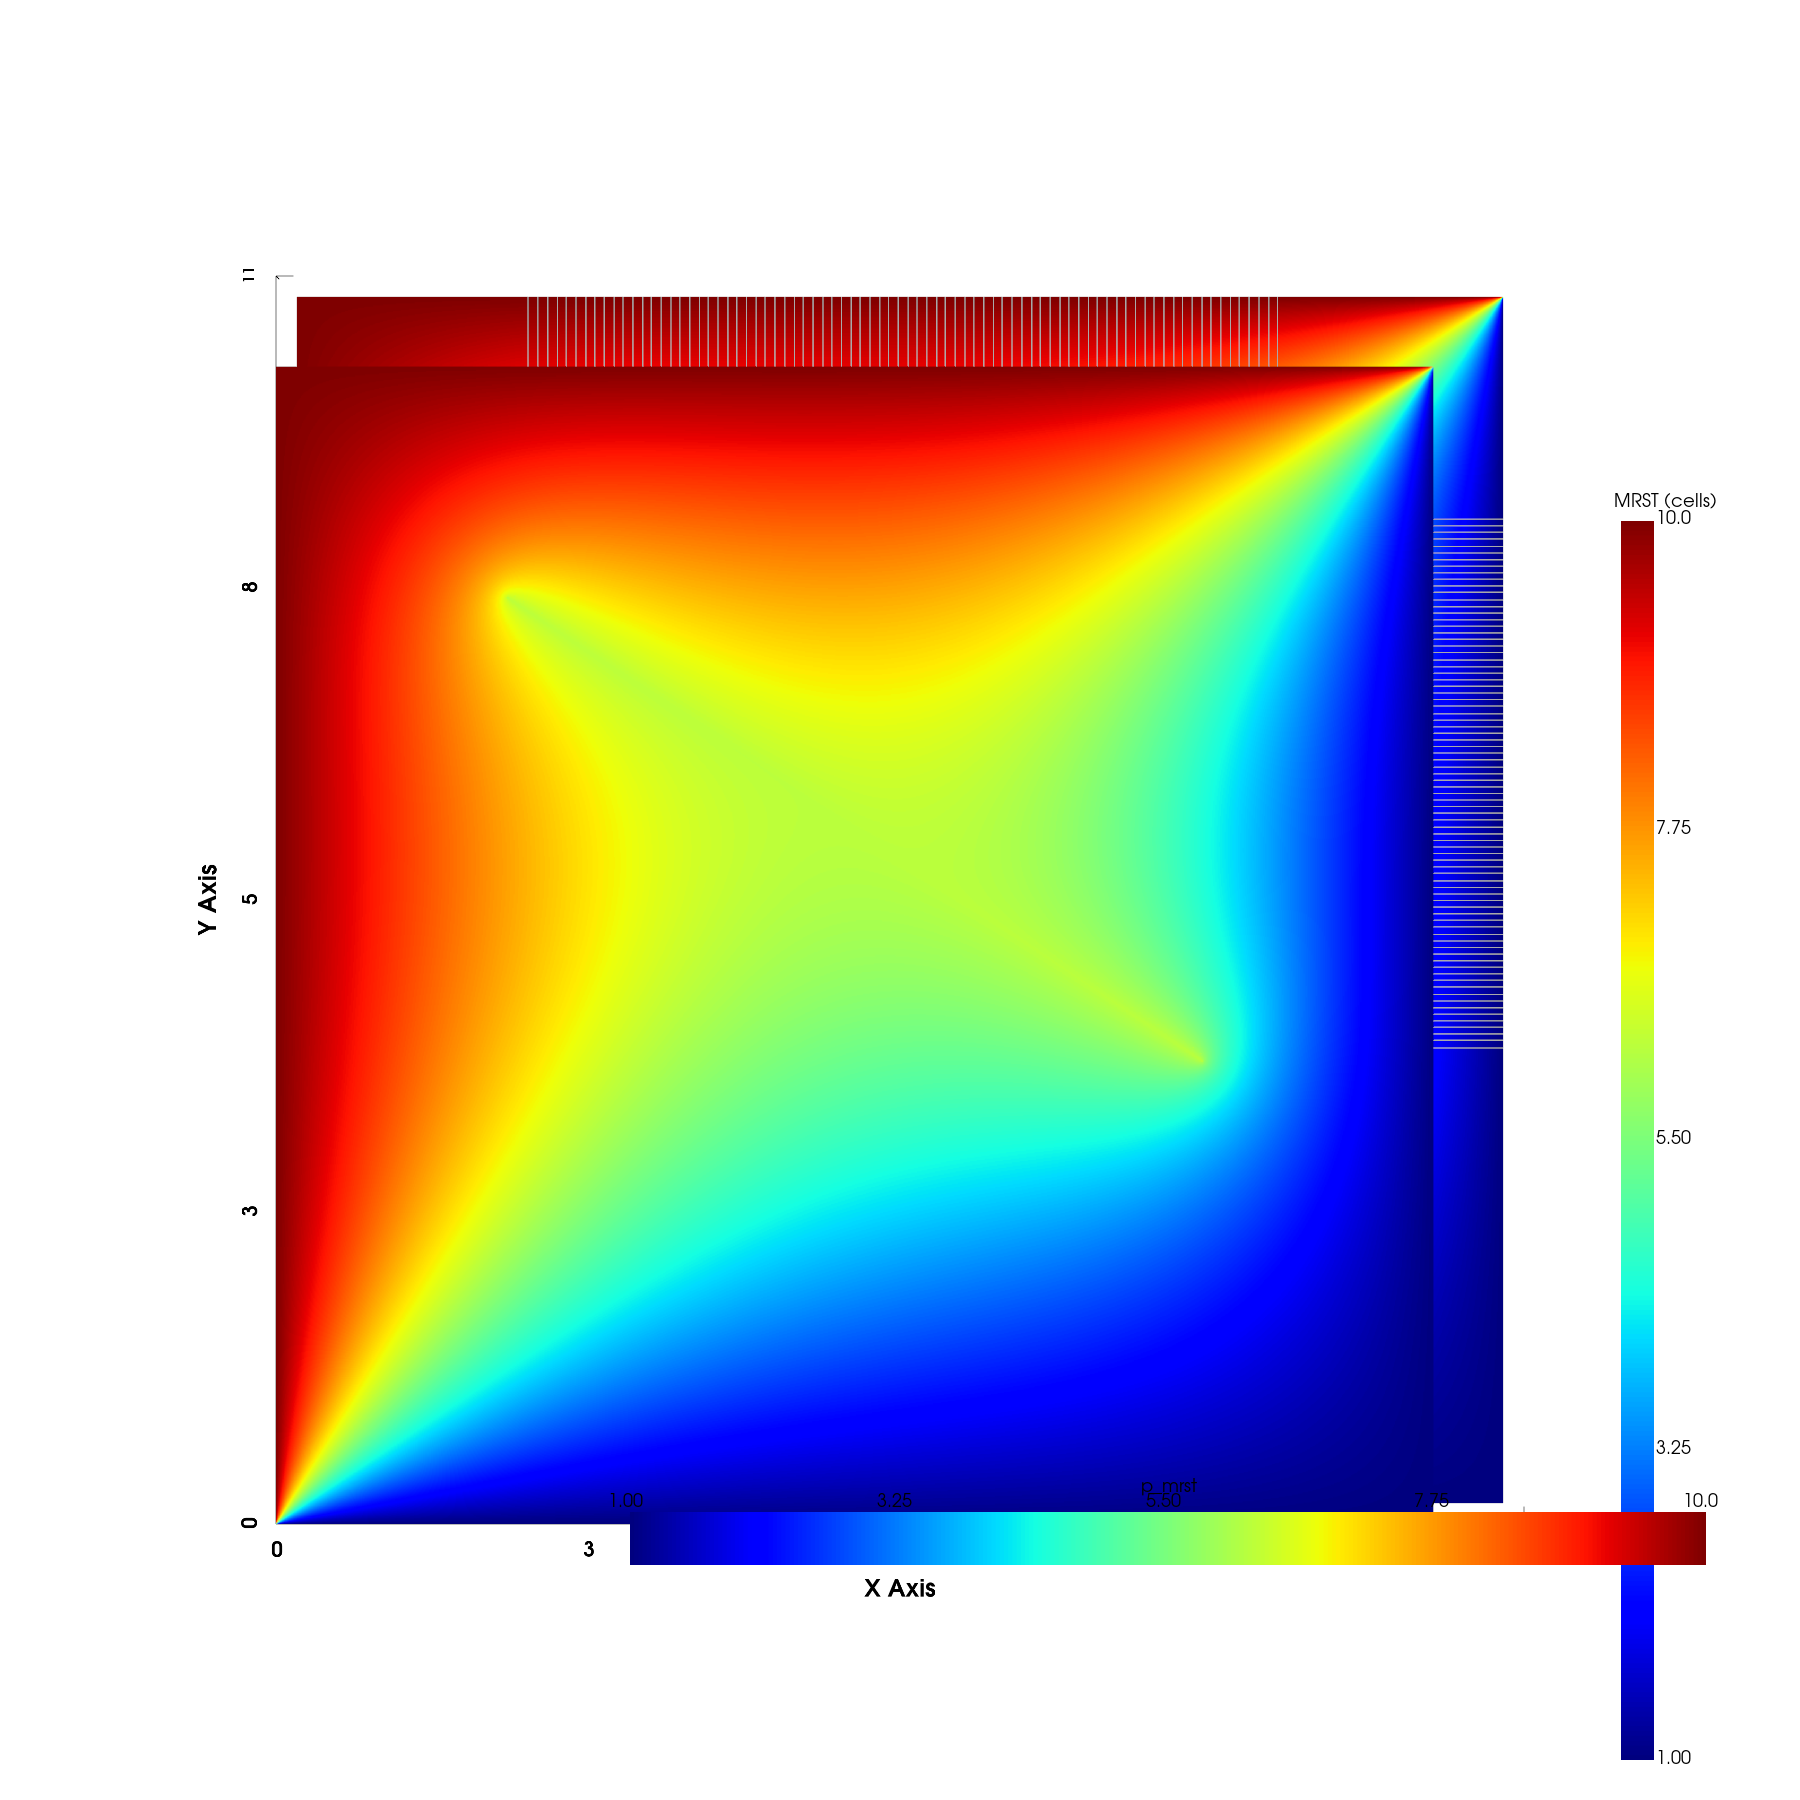

In [26]:
# Unique, sorted centroids along each axis
xs = np.sort(np.unique(x_mrst))
ys = np.sort(np.unique(y_mrst))
nx, ny = len(xs), len(ys)

# Build cell-centered field (accumulate/average in case of duplicates)
p2d = np.full((ny, nx), np.nan, float)
cnt = np.zeros((ny, nx), int)
ix = np.searchsorted(xs, x_mrst)
iy = np.searchsorted(ys, y_mrst)
for ixx, iyy, v in zip(ix, iy, p_mrst):
    if 0 <= ixx < nx and 0 <= iyy < ny:
        if np.isnan(p2d[iyy, ixx]):
            p2d[iyy, ixx] = v
        else:
            p2d[iyy, ixx] += v
        cnt[iyy, ixx] += 1
mask = cnt > 0
p2d[mask] /= cnt[mask]

# (Optional) nearest-neighbor fill to eliminate any remaining NaNs
if np.any(~np.isfinite(p2d)):
    from scipy.ndimage import distance_transform_edt
    valmask = np.isfinite(p2d)
    _, ii = distance_transform_edt(~valmask, return_indices=True)
    p2d = p2d[ii[0], ii[1]]

# Recover cell-edge coordinates from non-uniform centroids
# midpoints between centroids define interior edges; ends are extrapolated
xe = np.empty(nx + 1)
ye = np.empty(ny + 1)
xe[1:-1] = 0.5 * (xs[:-1] + xs[1:])
ye[1:-1] = 0.5 * (ys[:-1] + ys[1:])
xe[0]  = xs[0]  - (xe[1]   - xs[0])
xe[-1] = xs[-1] + (xs[-1]  - xe[-2])
ye[0]  = ys[0]  - (ye[1]   - ys[0])
ye[-1] = ys[-1] + (ys[-1]  - ye[-2])

# Build a rectilinear grid with non-uniform spacing
rg = pv.RectilinearGrid(xe, ye, np.array([0.0, 1.0]))
# rg.cell_data["p_mrst"] = np.asfortranarray(p2d).ravel(order="F")
rg.cell_data["p_mrst"] = np.asfortranarray(p2d).ravel(order="F")  # transpose, then F

# Plot (no lighting, no smoothing across cells)
plotter.add_mesh(
    rg, scalars="p_mrst", cmap="jet",
    show_edges=False, lighting=False,
    interpolate_before_map=False,  # keep per-cell colors
    clim=[vmin, vmax]
)
plotter.view_xy(); plotter.show()
